#  Projet EnergiSight — Modélisation
## Prédiction de la consommation énergétique
### Target : `SiteEnergyUse(kBtu)`


```

**Règle fondamentale :**
> La target est loggée **uniquement ici**, au moment du split.
> `y = np.log1p(df[TARGET])` → modèle entraîné sur log(y)
> `y_pred_reel = np.expm1(model.predict(X))` → prédictions en kBtu réels

**Métriques retenues :**
- **R²** sur log(y) — mesure la qualité d'ajustement du modèle
- **RMSE** en kBtu réels — mesure l'erreur en unités métier
- **MAPE** (Mean Absolute Percentage Error) — erreur relative, comparable entre bâtiments
- **MAE** en log-espace — robuste aux outliers résiduels

In [1]:
!pip install category-encoders
!pip install shap
!pip install xgboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.1 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
import shap
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import category_encoders as ce

import xgboost as xgb
import lightgbm as lgb
import joblib

sns.set_theme(style='whitegrid')
plt.rcParams['font.size'] = 11
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

DATA_PATH  = '/content/drive/MyDrive/D-CLIC/projet_energisight/data/df_modeling_ready.csv'
MODEL_DIR  = '/content/drive/MyDrive/D-CLIC/projet_energisight/models/'
TARGET     = 'siteenergyusekbtu'
SEED       = 42
TEST_SIZE  = 0.20
CV_FOLDS   = 5

df = pd.read_csv(DATA_PATH)
print(f'Dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes')
print(f'Target  : {TARGET}')
print(f'  min={df[TARGET].min():,.0f}  médiane={df[TARGET].median():,.0f}  '
      f'max={df[TARGET].max():,.0f} kBtu')

Dataset : 1648 lignes × 37 colonnes
Target  : siteenergyusekbtu
  min=16,809  médiane=2,593,203  max=873,923,712 kBtu


---
###  Préparation des features & split train/test

In [3]:
# ── Définition des features ───────────────────────────────────────────────────
# Colonnes à exclure : l'autre target et les identifiants résiduels
EXCLUDE = ['totalghgemissions', TARGET]

CAT_FEATURES = [
    'primarypropertytype',
    'neighborhood',
    'construction_era',
    'zipcode',
]
CAT_FEATURES = [c for c in CAT_FEATURES if c in df.columns]

NUM_FEATURES = [
    c for c in df.columns
    if c not in EXCLUDE + CAT_FEATURES
    and df[c].dtype in [np.float64, np.int64, float, int]
]

print(f'Features numériques : {len(NUM_FEATURES)}')
print(f'Features catégorielles : {len(CAT_FEATURES)} → {CAT_FEATURES}')
print(f'Total features : {len(NUM_FEATURES) + len(CAT_FEATURES)}')

X = df[NUM_FEATURES + CAT_FEATURES].copy()
y_raw = df[TARGET].copy()
y     = np.log1p(y_raw)   # ← transformation log uniquement ici

print(f'\nTarget log1p(y) : skew={y.skew():.3f}  '
      f'min={y.min():.2f}  médiane={y.median():.2f}  max={y.max():.2f}')

Features numériques : 27
Features catégorielles : 4 → ['primarypropertytype', 'neighborhood', 'construction_era', 'zipcode']
Total features : 31

Target log1p(y) : skew=0.281  min=9.73  médiane=14.77  max=20.59


In [4]:
# ── Split stratifié sur les quartiles de y ────────────────────────────────────
# Pourquoi stratifier ? Pour garantir que les très grands et très petits bâtiments
# sont représentés proportionnellement dans train et test.
y_bins = pd.qcut(y, q=4, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y_bins
)

print(f'Train : {X_train.shape[0]} lignes ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'Test  : {X_test.shape[0]} lignes ({X_test.shape[0]/len(X)*100:.0f}%)')
print(f'\nDistribution train/test (médiane log y) :')
print(f'  Train médiane : {y_train.median():.3f}')
print(f'  Test  médiane : {y_test.median():.3f}')

Train : 1318 lignes (80%)
Test  : 330 lignes (20%)

Distribution train/test (médiane log y) :
  Train médiane : 14.768
  Test  médiane : 14.764


---
### Pipelines d'encodage

Deux pipelines distincts :
- **OHE pipeline** : pour Ridge et Lasso — les modèles linéaires nécessitent des variables binaires
- **TE pipeline** : pour Random Forest, XGBoost, LightGBM — le Target Encoding préserve
  l'information ordinale et évite l'explosion de dimensions (22 types × OHE = 22 colonnes)

In [5]:
# ── Pipeline OHE (modèles linéaires) ─────────────────────────────────────────
ohe_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUM_FEATURES),
        ('cat', OneHotEncoder(
            handle_unknown='ignore',
            sparse_output=False,
            drop='first'   # évite la multicolinéarité parfaite
        ), CAT_FEATURES),
    ],
    remainder='drop'
)

# ── Pipeline Target Encoding (tree-based) ─────────────────────────────────────
# IMPORTANT : le TE est ajusté sur le train uniquement → pas de leakage
te_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', NUM_FEATURES),
        ('cat', ce.TargetEncoder(
            cols=CAT_FEATURES,
            smoothing=10,    # régularisation pour éviter l'overfitting sur petits groupes
            min_samples_leaf=5
        ), CAT_FEATURES),
    ],
    remainder='drop'
)

print(' Pipelines OHE et Target Encoding définis')
print(f'  OHE     : {len(NUM_FEATURES)} numériques + OHE catégorielles')
print(f'  TE      : {len(NUM_FEATURES)} numériques + TE catégorielles ({len(CAT_FEATURES)} cols → {len(CAT_FEATURES)} cols)')

 Pipelines OHE et Target Encoding définis
  OHE     : 27 numériques + OHE catégorielles
  TE      : 27 numériques + TE catégorielles (4 cols → 4 cols)


---
###  Utilitaires d'évaluation

In [6]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, model_name, cv=CV_FOLDS):
    """
    Évalue un modèle entraîné :
    - R², RMSE, MAE en espace log (pour comparer les modèles entre eux)
    - RMSE, MAPE en kBtu réels (pour l'interprétation métier)
    - CV R² sur le train (pour détecter l'overfitting)
    """
    # Prédictions en log-espace
    y_pred_log  = model.predict(X_te)
    y_pred_real = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_te)

    # Métriques log-espace
    r2   = r2_score(y_te, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_te, y_pred_log))
    mae_log  = mean_absolute_error(y_te, y_pred_log)

    # Métriques réelles
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real.clip(lower=1))) * 100

    # Cross-validation R² sur train
    kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=kf, scoring='r2')

    results = {
        'Modèle'          : model_name,
        'R² test'         : round(r2, 4),
        'CV R² (mean)'    : round(cv_scores.mean(), 4),
        'CV R² (std)'     : round(cv_scores.std(), 4),
        'RMSE log'        : round(rmse_log, 4),
        'MAE log'         : round(mae_log, 4),
        'RMSE kBtu réel'  : round(rmse_real / 1e6, 2),  # en millions kBtu
        'MAPE (%)'        : round(mape, 2),
    }

    print(f'\n  [{model_name}]')
    print(f'    R² test         : {r2:.4f}')
    print(f'    CV R² {cv}-fold  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
    print(f'    RMSE log        : {rmse_log:.4f}')
    print(f'    MAE log         : {mae_log:.4f}')
    print(f'    RMSE réel       : {rmse_real/1e6:.2f}M kBtu')
    print(f'    MAPE            : {mape:.2f}%')

    overfit = r2 - cv_scores.mean()
    if overfit > 0.05:
        print(f'    ⚠️  Possible overfitting (R² test - CV mean = {overfit:.3f})')

    return results

all_results = []
print(' Utilitaires définis')

 Utilitaires définis


---
###  Baseline — Ridge & Lasso

In [7]:
print('━━━ BASELINE : RIDGE & LASSO ━━━')

for ModelClass, name, alpha in [
    (Ridge, 'Ridge', 10.0),
    (Lasso, 'Lasso', 0.01),
]:
    pipe = Pipeline([
        ('preprocessor', ohe_preprocessor),
        ('model', ModelClass(alpha=alpha, random_state=SEED
                             if hasattr(ModelClass(), 'random_state') else 42))
    ])
    pipe.fit(X_train, y_train)
    res = evaluate_model(pipe, X_train, y_train, X_test, y_test, name)
    all_results.append(res)

━━━ BASELINE : RIDGE & LASSO ━━━

  [Ridge]
    R² test         : 0.9846
    CV R² 5-fold  : 0.9827 ± 0.0068
    RMSE log        : 0.1648
    MAE log         : 0.1000
    RMSE réel       : 14.79M kBtu
    MAPE            : 10.16%

  [Lasso]
    R² test         : 0.9850
    CV R² 5-fold  : 0.9806 ± 0.0108
    RMSE log        : 0.1626
    MAE log         : 0.0961
    RMSE réel       : 15.92M kBtu
    MAPE            : 9.27%


---
###  Random Forest

In [8]:
print('━━━ RANDOM FOREST ━━━')

rf_pipe = Pipeline([
    ('preprocessor', te_preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        max_features=0.5,    # sqrt équivalent pour la régression
        n_jobs=-1,
        random_state=SEED
    ))
])
rf_pipe.fit(X_train, y_train)
res = evaluate_model(rf_pipe, X_train, y_train, X_test, y_test, 'Random Forest')
all_results.append(res)

━━━ RANDOM FOREST ━━━

  [Random Forest]
    R² test         : 0.9897
    CV R² 5-fold  : 0.9857 ± 0.0056
    RMSE log        : 0.1351
    MAE log         : 0.0795
    RMSE réel       : 18.21M kBtu
    MAPE            : 7.72%


---
### XGBoost

In [9]:
print('━━━ XGBOOST ━━━')

xgb_pipe = Pipeline([
    ('preprocessor', te_preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbosity=0
    ))
])
xgb_pipe.fit(X_train, y_train)
res = evaluate_model(xgb_pipe, X_train, y_train, X_test, y_test, 'XGBoost')
all_results.append(res)

━━━ XGBOOST ━━━

  [XGBoost]
    R² test         : 0.9901
    CV R² 5-fold  : 0.9883 ± 0.0043
    RMSE log        : 0.1321
    MAE log         : 0.0698
    RMSE réel       : 17.81M kBtu
    MAPE            : 6.85%


---
### LightGBM

In [10]:
print('━━━ LIGHTGBM ━━━')

lgb_pipe = Pipeline([
    ('preprocessor', te_preprocessor),
    ('model', lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        min_child_samples=10,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1
    ))
])
lgb_pipe.fit(X_train, y_train)
res = evaluate_model(lgb_pipe, X_train, y_train, X_test, y_test, 'LightGBM')
all_results.append(res)

━━━ LIGHTGBM ━━━

  [LightGBM]
    R² test         : 0.9902
    CV R² 5-fold  : 0.9881 ± 0.0034
    RMSE log        : 0.1317
    MAE log         : 0.0703
    RMSE réel       : 17.46M kBtu
    MAPE            : 6.96%


---
### Comparaison des modèles

In [11]:
results_df = pd.DataFrame(all_results).set_index('Modèle')

print('═' * 70)
print('  COMPARAISON DES MODÈLES — PRÉDICTION CONSOMMATION ÉNERGÉTIQUE')
print('═' * 70)
display(results_df.style
    .background_gradient(cmap='RdYlGn', subset=['R² test', 'CV R² (mean)'], vmin=0, vmax=1)
    .background_gradient(cmap='RdYlGn_r', subset=['RMSE log', 'MAE log', 'MAPE (%)'])
    .format({
        'R² test': '{:.4f}', 'CV R² (mean)': '{:.4f}', 'CV R² (std)': '{:.4f}',
        'RMSE log': '{:.4f}', 'MAE log': '{:.4f}',
        'RMSE kBtu réel': '{:.2f}M', 'MAPE (%)': '{:.2f}%'
    })
)

best_model_name = results_df['R² test'].idxmax()
best_r2 = results_df['R² test'].max()
print(f'\n Meilleur modèle : {best_model_name}  (R² = {best_r2:.4f})')

══════════════════════════════════════════════════════════════════════
  COMPARAISON DES MODÈLES — PRÉDICTION CONSOMMATION ÉNERGÉTIQUE
══════════════════════════════════════════════════════════════════════


,R² test,CV R² (mean),CV R² (std),RMSE log,MAE log,RMSE kBtu réel,MAPE (%)
Modèle,,,,,,,
Ridge,0.9846,0.9827,0.0068,0.1648,0.1000,14.79M,10.16%
Lasso,0.9850,0.9806,0.0108,0.1626,0.0961,15.92M,9.27%
Random Forest,0.9897,0.9857,0.0056,0.1351,0.0795,18.21M,7.72%
XGBoost,0.9901,0.9883,0.0043,0.1321,0.0698,17.81M,6.85%
LightGBM,0.9902,0.9881,0.0034,0.1317,0.0703,17.46M,6.96%



 Meilleur modèle : LightGBM  (R² = 0.9902)


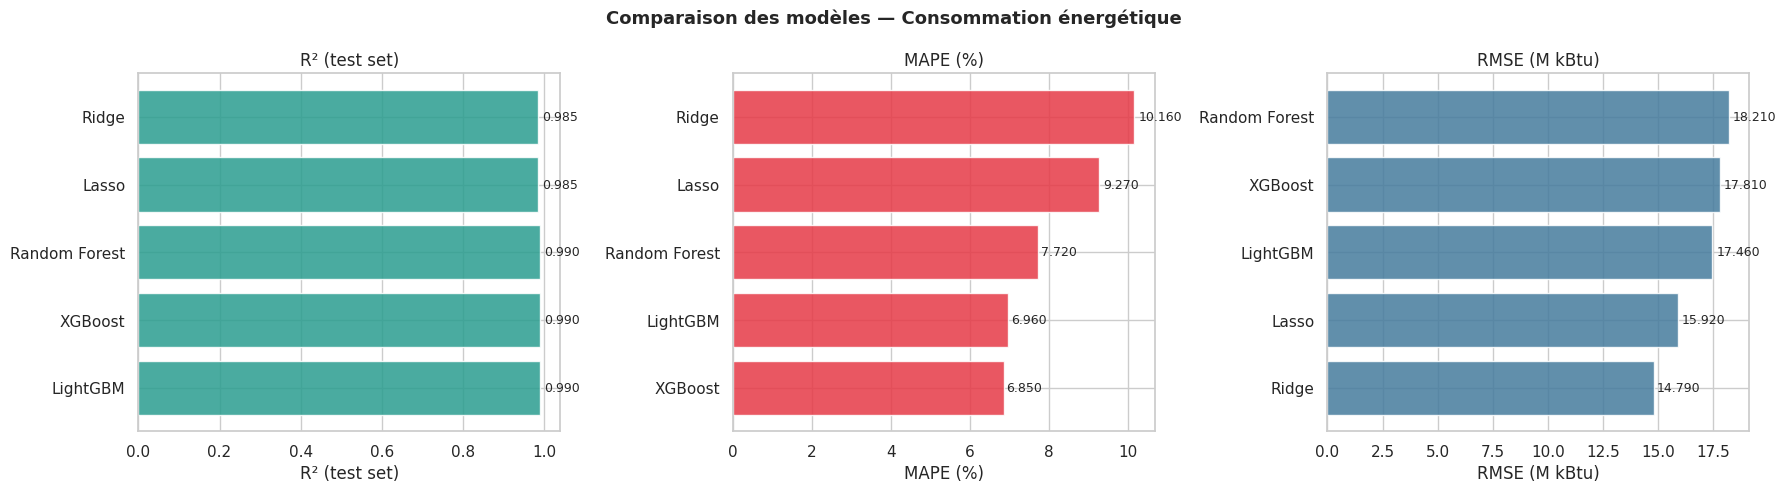

In [12]:
# Graphique comparatif
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Comparaison des modèles — Consommation énergétique',
             fontsize=13, fontweight='bold')

metrics = [
    ('R² test',   'R² (test set)',  True,  '#2a9d8f'),
    ('MAPE (%)',  'MAPE (%)',       False, '#e63946'),
    ('RMSE kBtu réel', 'RMSE (M kBtu)', False, '#457b9d'),
]

for ax, (col, label, higher_better, color) in zip(axes, metrics):
    vals = results_df[col].sort_values(ascending=not higher_better)
    bars = ax.barh(vals.index, vals.values, color=color, alpha=0.85)
    ax.set_title(label)
    ax.set_xlabel(label)
    for bar, val in zip(bars, vals.values):
        ax.text(bar.get_width() + bar.get_width()*0.01,
                bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

---
### Analyse du meilleur modèle

In [13]:
from sklearn.model_selection import KFold, cross_val_score

y_test_real = np.expm1(y_test) # Define y_test_real globally for use in full_evaluate

def full_evaluate(name, pipe):
    """
    Évalue un modèle entraîné :
    - R², RMSE, MAE en espace log (pour comparer les modèles entre eux)
    - RMSE, MAPE en kBtu réels (pour l'interprétation métier)
    - CV R² sur le train (pour détecter l'overfitting)
    """
    y_pred_log  = pipe.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)

    r2       = r2_score(y_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    mae_log  = mean_absolute_error(y_test, y_pred_log)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mape     = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real.clip(lower=1))) * 100
    # Médiane APE — plus robuste aux outliers que la MAPE
    mdape    = np.median(np.abs((y_test_real - y_pred_real) / y_test_real.clip(lower=1))) * 100

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    cv = cross_val_score(pipe, X_train, y_train, cv=kf, scoring='r2')
    overfit = r2 - cv.mean()

    return {
        'Modèle'        : name,
        'R² test'       : round(r2, 4),
        'CV R² mean'    : round(cv.mean(), 4),
        'CV R² std'     : round(cv.std(), 4),
        'Overfitting'   : round(overfit, 4),
        'RMSE log'      : round(rmse_log, 4),
        'MAE log'       : round(mae_log, 4),
        'RMSE réel (M)' : round(rmse_real / 1e6, 2),
        'MAPE (%)'      : round(mape, 2),
        'MdAPE (%)'     : round(mdape, 2),   # médiane — plus robuste
    }

# Define pipes dictionary with all trained models
pipes = {
    'Ridge': Pipeline([
        ('preprocessor', ohe_preprocessor),
        ('model', Ridge(alpha=10.0, random_state=SEED))
    ]).fit(X_train, y_train),
    'Lasso': Pipeline([
        ('preprocessor', ohe_preprocessor),
        ('model', Lasso(alpha=0.01, random_state=SEED))
    ]).fit(X_train, y_train),
    'Random Forest': rf_pipe, # Assuming rf_pipe is the trained Random Forest pipeline
    'XGBoost': xgb_pipe,     # Assuming xgb_pipe is the trained XGBoost pipeline
    'LightGBM': lgb_pipe    # Assuming lgb_pipe is the trained LightGBM pipeline
}

results = [full_evaluate(n, p) for n, p in pipes.items()]
res_df  = pd.DataFrame(results).set_index('Modèle')

# Score composite : rang moyen sur 4 critères (R², MAPE, MdAPE, CV std)
res_df['Rang R²']    = res_df['R² test'].rank(ascending=False)
res_df['Rang MAPE']  = res_df['MAPE (%)'].rank(ascending=True)
res_df['Rang MdAPE'] = res_df['MdAPE (%)'].rank(ascending=True)
res_df['Rang Stab']  = res_df['CV R² std'].rank(ascending=True)  # plus petit = plus stable
res_df['Score composite'] = (res_df[['Rang R²','Rang MAPE','Rang MdAPE','Rang Stab']].mean(axis=1))

display(res_df.style
    .background_gradient(cmap='RdYlGn',   subset=['R² test','CV R² mean'], vmin=0.97, vmax=1.0)
    .background_gradient(cmap='RdYlGn_r', subset=['MAPE (%)','MdAPE (%)','Overfitting'])
    .background_gradient(cmap='RdYlGn',   subset=['Score composite'], vmin=1, vmax=5)
    .format({'R² test':'{:.4f}','CV R² mean':'{:.4f}','CV R² std':'{:.4f}',
             'Overfitting':'{:.4f}','RMSE log':'{:.4f}','MAE log':'{:.4f}',
             'RMSE réel (M)':'{:.2f}M','MAPE (%)':'{:.2f}%','MdAPE (%)':'{:.2f}%',
             'Score composite':'{:.2f}'}))

best_name = res_df['Score composite'].idxmin()
print(f'\n Meilleur modèle (score composite) : {best_name}')
print(f'   R²={res_df.loc[best_name,"R² test"]:.4f}  '
      f'MAPE={res_df.loc[best_name,"MAPE (%)"]:.2f}%  '
      f'MdAPE={res_df.loc[best_name,"MdAPE (%)"]:.2f}%  '
      f'Overfitting={res_df.loc[best_name,"Overfitting"]:.4f}')

,R² test,CV R² mean,CV R² std,Overfitting,RMSE log,MAE log,RMSE réel (M),MAPE (%),MdAPE (%),Rang R²,Rang MAPE,Rang MdAPE,Rang Stab,Score composite
Modèle,,,,,,,,,,,,,,
Ridge,0.9846,0.9827,0.0068,0.0019,0.1648,0.1000,14.79M,10.16%,6.71%,5.000000,5.000000,4.000000,4.000000,4.50
Lasso,0.9850,0.9806,0.0108,0.0044,0.1626,0.0961,15.92M,9.27%,6.79%,4.000000,4.000000,5.000000,5.000000,4.50
Random Forest,0.9897,0.9857,0.0056,0.0040,0.1351,0.0795,18.21M,7.72%,4.66%,3.000000,3.000000,3.000000,3.000000,3.00
XGBoost,0.9901,0.9883,0.0043,0.0018,0.1321,0.0698,17.81M,6.85%,3.80%,2.000000,1.000000,1.000000,2.000000,1.50
LightGBM,0.9902,0.9881,0.0034,0.0021,0.1317,0.0703,17.46M,6.96%,4.15%,1.000000,2.000000,2.000000,1.000000,1.50



 Meilleur modèle (score composite) : XGBoost
   R²=0.9901  MAPE=6.85%  MdAPE=3.80%  Overfitting=0.0018


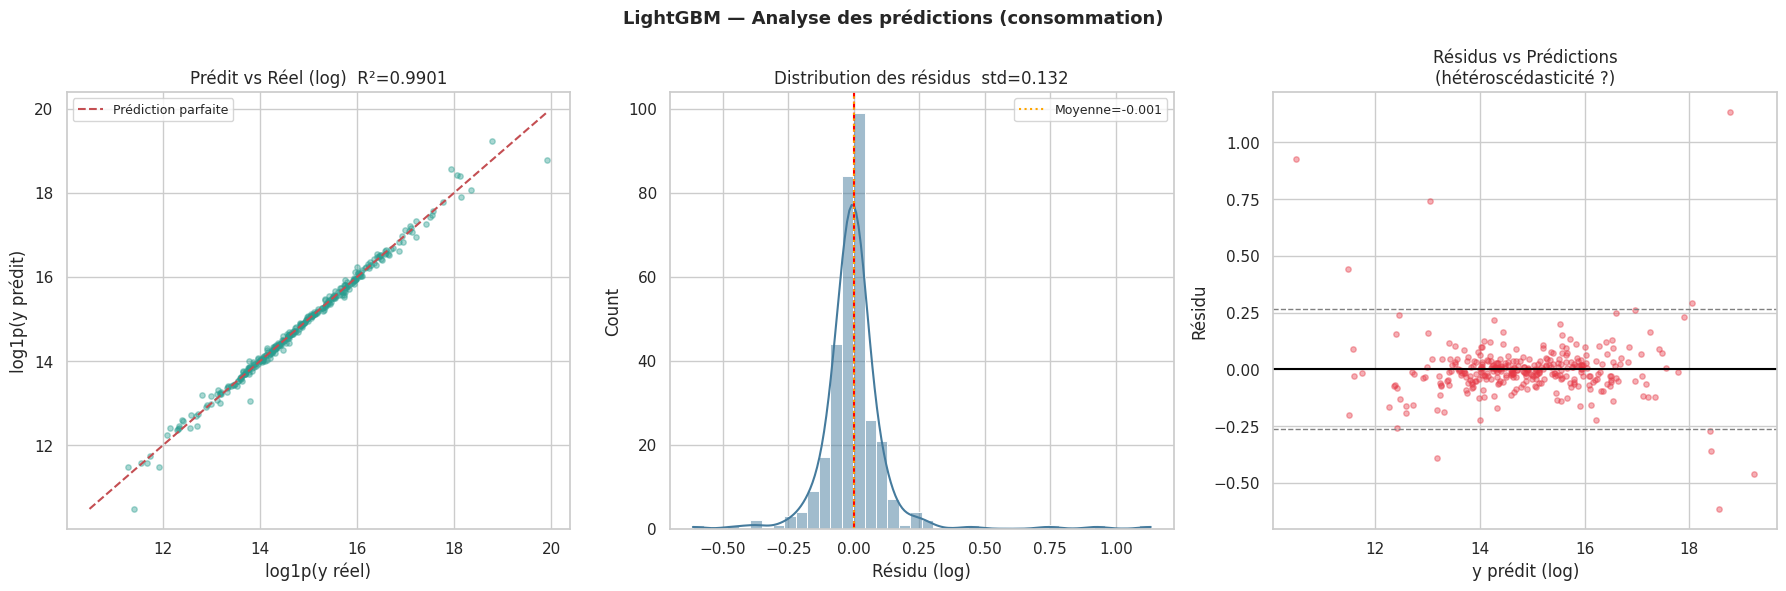

Résidus — moyenne: -0.0011  std: 0.1321
% résidus dans [-2σ, +2σ] : 97.0%


In [14]:
# ── Graphique prédictions vs réalité ─────────────────────────────────────────
best_pipe = pipes[best_name] # Define best_pipe using the best_name from previous cell
y_pred_log  = best_pipe.predict(X_test)
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)
residuals   = y_test.values - y_pred_log

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'{best_model_name} — Analyse des prédictions (consommation)',
             fontsize=13, fontweight='bold')

# Prédit vs réel en log-espace
axes[0].scatter(y_test, y_pred_log, alpha=0.4, s=15, color='#2a9d8f')
lims = [min(y_test.min(), y_pred_log.min()), max(y_test.max(), y_pred_log.max())]
axes[0].plot(lims, lims, 'r--', lw=1.5, label='Prédiction parfaite')
axes[0].set_xlabel('log1p(y réel)')
axes[0].set_ylabel('log1p(y prédit)')
axes[0].set_title(f'Prédit vs Réel (log)  R²={r2_score(y_test, y_pred_log):.4f}')
axes[0].legend(fontsize=9)

# Distribution des résidus
sns.histplot(residuals, bins=40, kde=True, ax=axes[1], color='#457b9d')
axes[1].axvline(0, color='red', linestyle='--', lw=1.5)
axes[1].axvline(residuals.mean(), color='orange', linestyle=':',
                lw=1.5, label=f'Moyenne={residuals.mean():.3f}')
axes[1].set_title(f'Distribution des résidus  std={residuals.std():.3f}')
axes[1].set_xlabel('Résidu (log)')
axes[1].legend(fontsize=9)

# Résidus vs valeurs prédites (hétéroscédasticité ?)
axes[2].scatter(y_pred_log, residuals, alpha=0.4, s=15, color='#e63946')
axes[2].axhline(0, color='black', lw=1.5)
axes[2].axhline( 2*residuals.std(), color='gray', linestyle='--', lw=1)
axes[2].axhline(-2*residuals.std(), color='gray', linestyle='--', lw=1)
axes[2].set_xlabel('y prédit (log)')
axes[2].set_ylabel('Résidu')
axes[2].set_title('Résidus vs Prédictions\n(hétéroscédasticité ?)')

plt.tight_layout()
plt.show()

print(f'Résidus — moyenne: {residuals.mean():.4f}  std: {residuals.std():.4f}')
print(f'% résidus dans [-2σ, +2σ] : {(np.abs(residuals) < 2*residuals.std()).mean()*100:.1f}%')


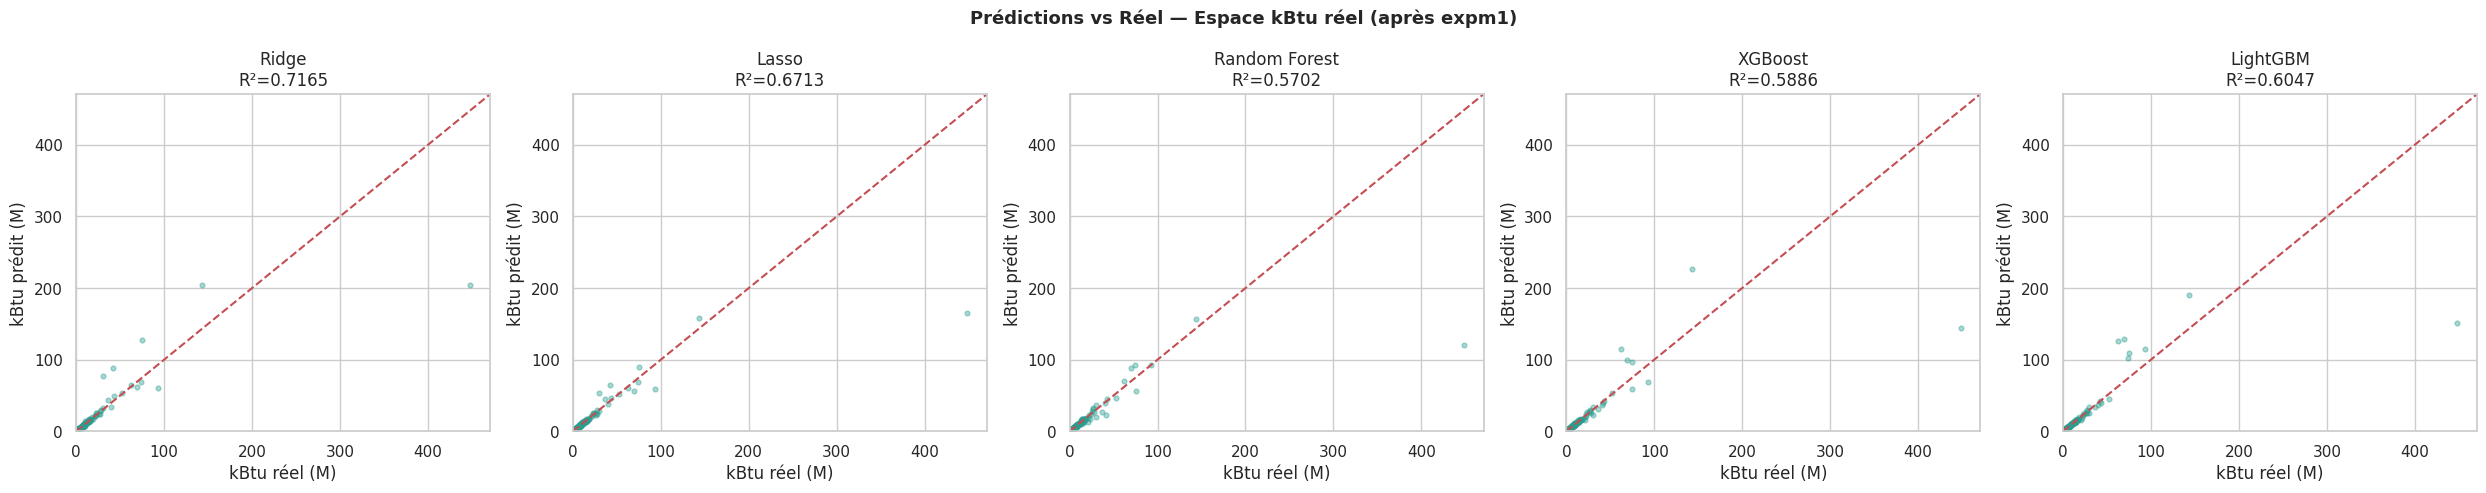

In [15]:
# Scatter prédit vs réel en kBtu — pour chaque modèle
fig, axes = plt.subplots(1, len(pipes), figsize=(5*len(pipes), 5))
fig.suptitle('Prédictions vs Réel — Espace kBtu réel (après expm1)',
             fontsize=13, fontweight='bold')

for ax, (name, pipe) in zip(axes, pipes.items()):
    y_pred_real = np.expm1(pipe.predict(X_test))
    r2_real = r2_score(y_test_real, y_pred_real)

    ax.scatter(y_test_real / 1e6, y_pred_real / 1e6,
               alpha=0.4, s=12, color='#2a9d8f')
    lims = [0, max(y_test_real.max(), y_pred_real.max()) / 1e6 * 1.05]
    ax.plot(lims, lims, 'r--', lw=1.5)
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel('kBtu réel (M)')
    ax.set_ylabel('kBtu prédit (M)')
    ax.set_title(f'{name}\nR²={r2_real:.4f}')

plt.tight_layout()
plt.show()

In [16]:
# Zoom sur les petits bâtiments (médiane et en dessous)
# → là où la MAPE est la plus volatile
median_kbtu = y_test_real.median()
mask_small  = y_test_real <= median_kbtu
mask_large  = y_test_real > median_kbtu

print('Performance par taille de bâtiment (meilleur modèle = {} ) :'.format(best_name))
best_pipe = pipes[best_name]
y_pred_real = np.expm1(best_pipe.predict(X_test))

for label, mask in [('Petits (≤ médiane)', mask_small), ('Grands (> médiane)', mask_large)]:
    mape_sub = np.mean(np.abs(
        (y_test_real[mask] - y_pred_real[mask]) / y_test_real[mask].clip(lower=1)
    )) * 100
    r2_sub = r2_score(y_test_real[mask], y_pred_real[mask])
    print(f'  {label:<25} N={mask.sum():<5} MAPE={mape_sub:.2f}%  R²={r2_sub:.4f}')

print()
print(f'Médiane de la target : {median_kbtu/1e6:.2f}M kBtu')

Performance par taille de bâtiment (meilleur modèle = XGBoost ) :
  Petits (≤ médiane)        N=165   MAPE=6.60%  R²=0.9800
  Grands (> médiane)        N=165   MAPE=7.10%  R²=0.5619

Médiane de la target : 2.58M kBtu


In [17]:
# Extraire le modèle tree-based et les données transformées
# On travaille sur LightGBM (ou XGBoost selon le meilleur)
shap_model_name = best_name if best_name in ['LightGBM','XGBoost','Random Forest'] else 'LightGBM'
shap_pipe = pipes[shap_model_name]

# Transformer les données via le preprocessor
X_train_transformed = shap_pipe.named_steps['preprocessor'].transform(X_train)
X_test_transformed  = shap_pipe.named_steps['preprocessor'].transform(X_test)

# Noms des features après Target Encoding
try:
    feat_names = shap_pipe.named_steps['preprocessor'].get_feature_names_out()
    feat_names = [f.replace('num__','').replace('cat__','') for f in feat_names]
except:
    feat_names = NUM_FEATURES + CAT_FEATURES

# Convertir en DataFrame pour SHAP
X_test_shap  = pd.DataFrame(X_test_transformed,  columns=feat_names)
X_train_shap = pd.DataFrame(X_train_transformed, columns=feat_names)

# TreeExplainer
explainer   = shap.TreeExplainer(shap_pipe.named_steps['model'])
shap_values = explainer.shap_values(X_test_shap)

print(f'✓ SHAP calculé sur {shap_model_name}')
print(f'  Shape SHAP values : {np.array(shap_values).shape}')

✓ SHAP calculé sur XGBoost
  Shape SHAP values : (330, 31)


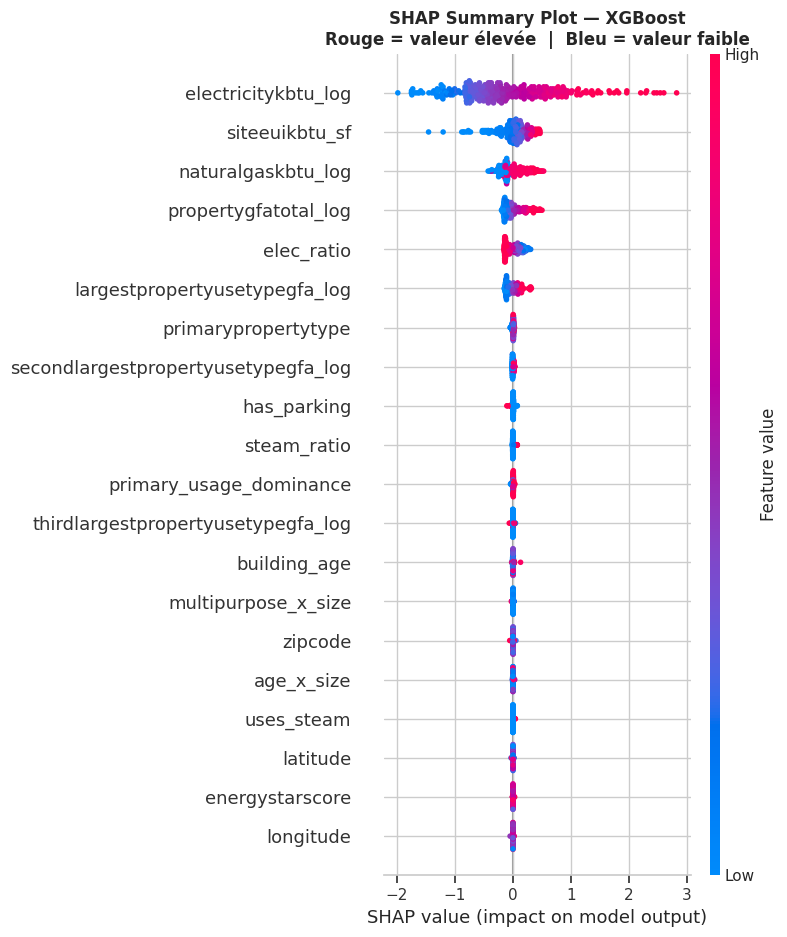

In [18]:
# ── SHAP Summary Plot (beeswarm) ──────────────────────────────────────────────
# Lecture du graphique :
# - Axe X : valeur SHAP = contribution à la prédiction (positif = hausse consommation)
# - Couleur : valeur de la feature (rouge = haute, bleu = basse)
# - Chaque point = un bâtiment du test set

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, X_test_shap,
    max_display=20,
    plot_type='dot',
    show=False
)
plt.title(f'SHAP Summary Plot — {shap_model_name}\n'
          'Rouge = valeur élevée  |  Bleu = valeur faible',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

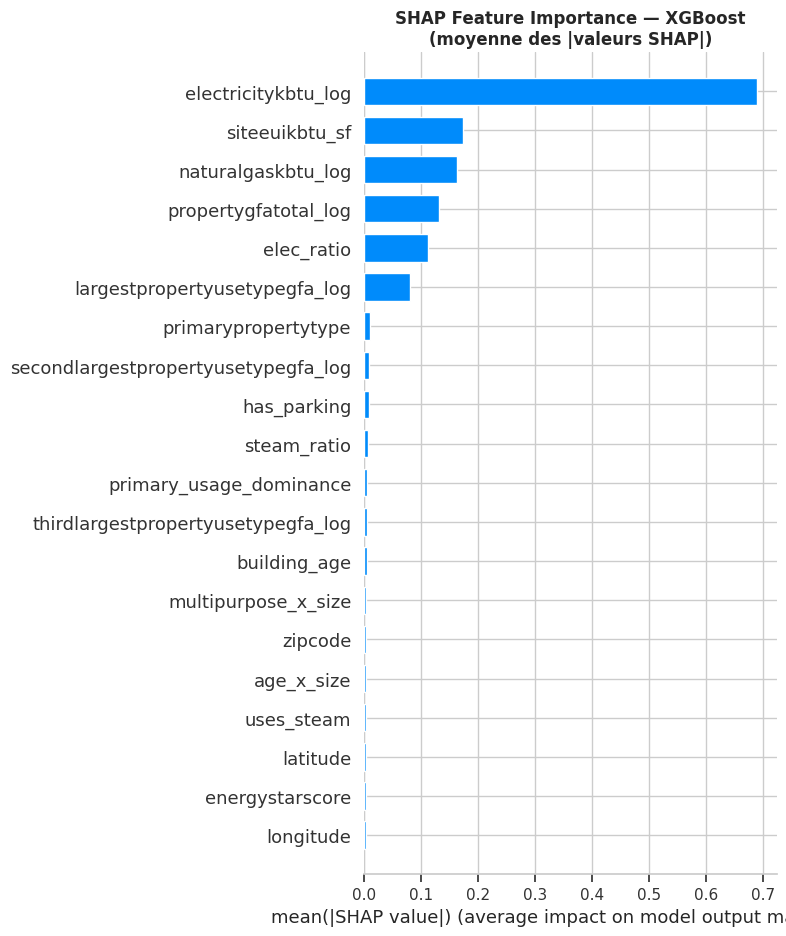

In [19]:
# ── SHAP Bar Plot — importance globale ───────────────────────────────────────
plt.figure(figsize=(10, 7))
shap.summary_plot(
    shap_values, X_test_shap,
    max_display=20,
    plot_type='bar',
    show=False
)
plt.title(f'SHAP Feature Importance — {shap_model_name}\n'
          '(moyenne des |valeurs SHAP|)',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

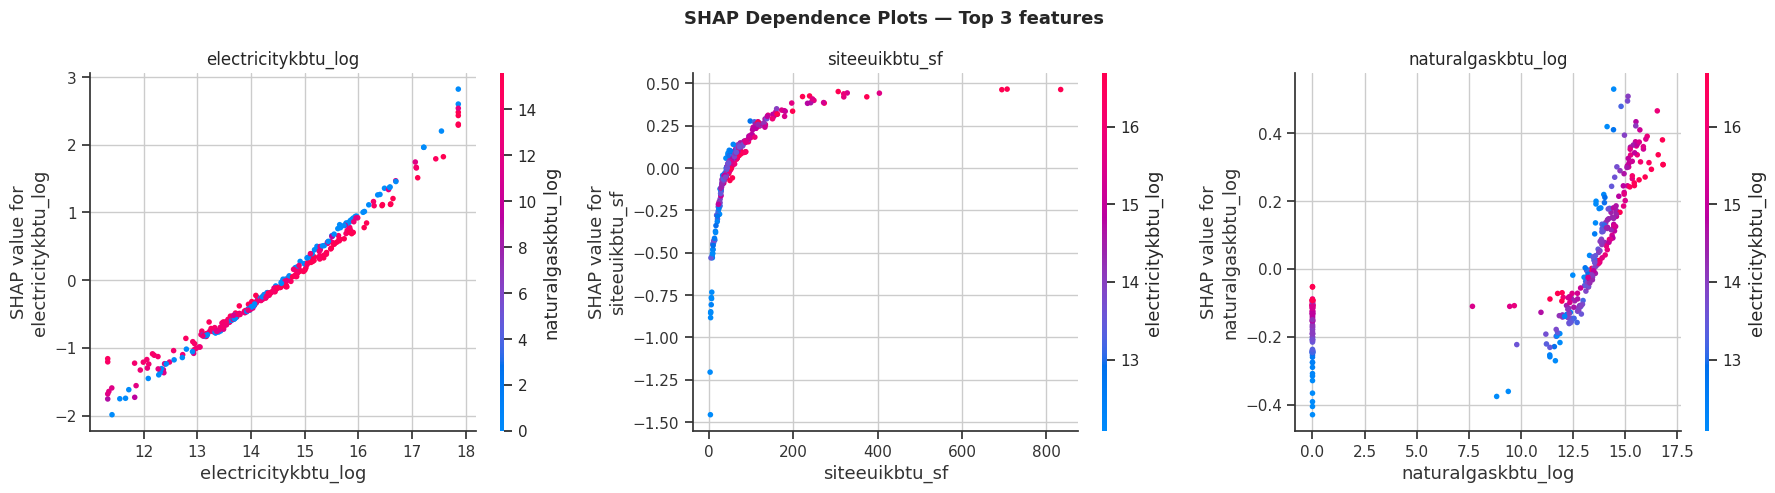

In [20]:
# ── SHAP Dependence Plot — top 3 features ────────────────────────────────────
# Montre comment la valeur d'une feature influence la prédiction
shap_abs_mean = np.abs(shap_values).mean(axis=0)
top3_idx      = shap_abs_mean.argsort()[::-1][:3]
top3_features = [feat_names[i] for i in top3_idx]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('SHAP Dependence Plots — Top 3 features',
             fontsize=13, fontweight='bold')

for ax, feat in zip(axes, top3_features):
    if feat in X_test_shap.columns:
        feat_idx = list(X_test_shap.columns).index(feat)
        shap.dependence_plot(
            feat_idx, shap_values, X_test_shap,
            ax=ax, show=False
        )
        ax.set_title(f'{feat}')

plt.tight_layout()
plt.show()


─── Explication individuelle : Grande consommation ───
  Valeur réelle   : 143.42M kBtu
  Valeur prédite  : 227.08M kBtu


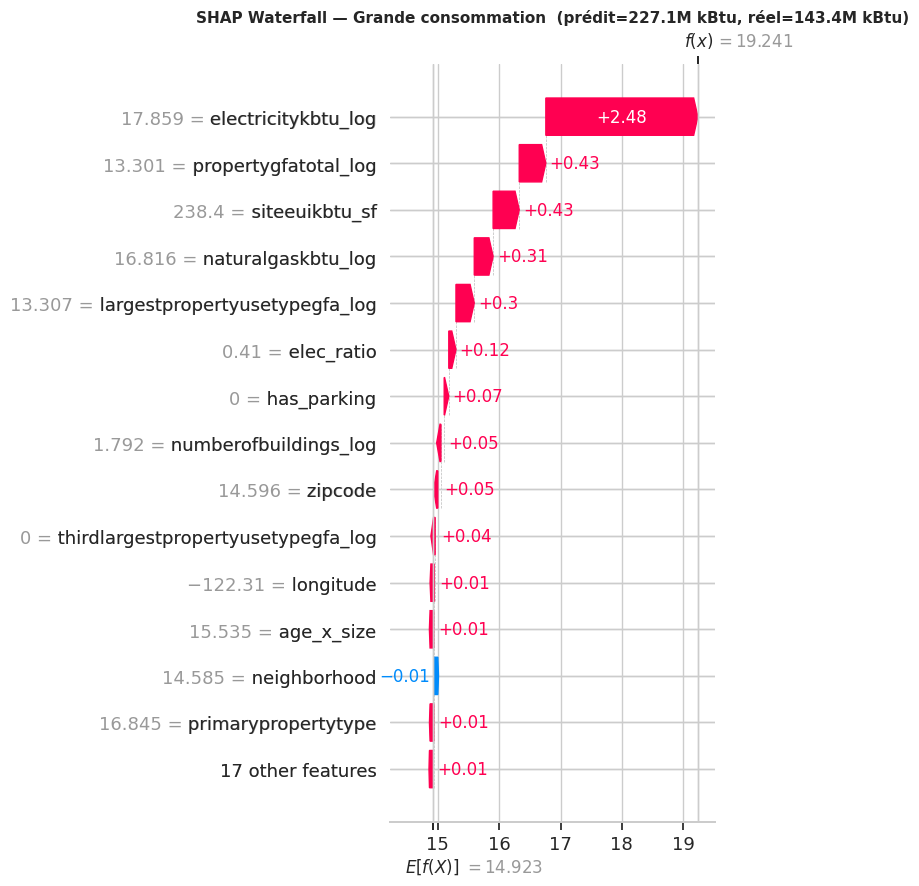


─── Explication individuelle : Petite consommation ───
  Valeur réelle   : 0.09M kBtu
  Valeur prédite  : 0.04M kBtu


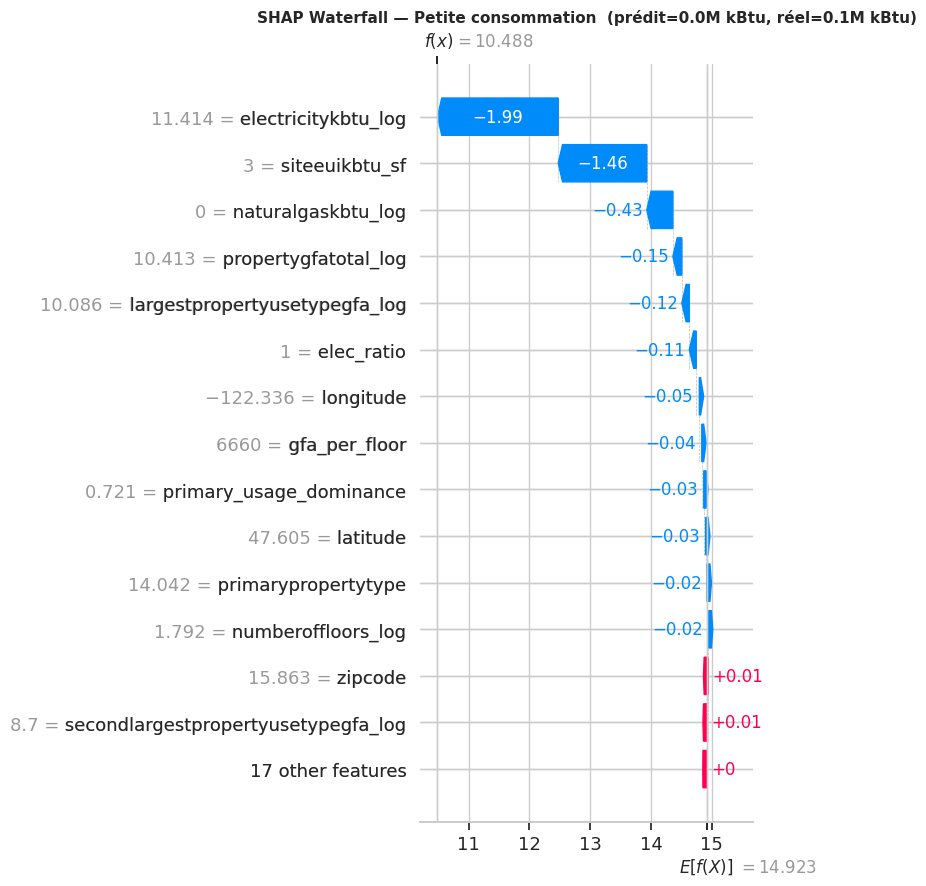

In [21]:
# ── SHAP Waterfall — explication d'une prédiction individuelle ───────────────
# Exemple : le bâtiment avec la plus grande consommation prédite
idx_max = np.argmax(shap_pipe.predict(X_test))
idx_min = np.argmin(shap_pipe.predict(X_test))

for idx, label in [(idx_max, 'Grande consommation'), (idx_min, 'Petite consommation')]:
    print(f'\n─── Explication individuelle : {label} ───')
    pred_log  = shap_pipe.predict(X_test)[idx]
    pred_real = np.expm1(pred_log)
    real_real = np.expm1(y_test.values[idx])
    print(f'  Valeur réelle   : {real_real/1e6:.2f}M kBtu')
    print(f'  Valeur prédite  : {pred_real/1e6:.2f}M kBtu')

    explanation = shap.Explanation(
        values        = shap_values[idx],
        base_values   = explainer.expected_value,
        data          = X_test_shap.iloc[idx].values,
        feature_names = feat_names
    )
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(explanation, max_display=15, show=False)
    plt.title(f'SHAP Waterfall — {label}  '
              f'(prédit={pred_real/1e6:.1f}M kBtu, réel={real_real/1e6:.1f}M kBtu)',
              fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [22]:
# ── Tableau récapitulatif SHAP — top 15 features avec sens ───────────────────
shap_df = pd.DataFrame({
    'Feature'                     : feat_names,
    'Importance SHAP (|mean|)'    : np.abs(shap_values).mean(axis=0),
    'Effet moyen (mean)'          : shap_values.mean(axis=0),
}).sort_values('Importance SHAP (|mean|)', ascending=False).head(15)

shap_df['Direction'] = shap_df['Effet moyen (mean)'].apply(
    lambda x: '↑ Augmente consommation' if x > 0 else '↓ Diminue consommation'
)

print('TOP 15 FEATURES — Analyse SHAP :')
display(shap_df.style
    .background_gradient(cmap='YlOrRd', subset=['Importance SHAP (|mean|)'])
    .format({
        'Importance SHAP (|mean|)': '{:.4f}',
        'Effet moyen (mean)': '{:+.4f}'
    })
)

print()
print('═' * 55)
print('  BILAN FINAL — MEILLEUR MODÈLE SÉLECTIONNÉ')
print('═' * 55)
print(f'  Modèle          : {best_name}')
print(f'  R² test         : {res_df.loc[best_name,"R² test"]:.4f}')
print(f'  MAPE            : {res_df.loc[best_name,"MAPE (%)"]:.2f}%')
print(f'  MdAPE           : {res_df.loc[best_name,"MdAPE (%)"]:.2f}%')
print(f'  Overfitting     : {res_df.loc[best_name,"Overfitting"]:.4f}')
print(f'  Stabilité CV    : std={res_df.loc[best_name,"CV R² std"]:.4f}')
print()
print('  Top 3 drivers selon SHAP :')
for _, row in shap_df.head(3).iterrows():
    print(f'    • {row["Feature"]:<35} {row["Direction"]}')

TOP 15 FEATURES — Analyse SHAP :


,Feature,Importance SHAP (|mean|),Effet moyen (mean),Direction
9,electricitykbtu_log,0.6901,-0.0719,↓ Diminue consommation
4,siteeuikbtu_sf,0.1736,+0.0143,↑ Augmente consommation
8,naturalgaskbtu_log,0.1633,-0.0027,↓ Diminue consommation
10,propertygfatotal_log,0.1315,-0.0080,↓ Diminue consommation
19,elec_ratio,0.1112,+0.0097,↑ Augmente consommation
7,largestpropertyusetypegfa_log,0.0808,-0.0083,↓ Diminue consommation
27,primarypropertytype,0.0091,-0.0000,↓ Diminue consommation
13,secondlargestpropertyusetypegfa_log,0.0087,+0.0018,↑ Augmente consommation
16,has_parking,0.0084,+0.0002,↑ Augmente consommation
20,steam_ratio,0.0068,-0.0004,↓ Diminue consommation



═══════════════════════════════════════════════════════
  BILAN FINAL — MEILLEUR MODÈLE SÉLECTIONNÉ
═══════════════════════════════════════════════════════
  Modèle          : XGBoost
  R² test         : 0.9901
  MAPE            : 6.85%
  MdAPE           : 3.80%
  Overfitting     : 0.0018
  Stabilité CV    : std=0.0043

  Top 3 drivers selon SHAP :
    • electricitykbtu_log                 ↓ Diminue consommation
    • siteeuikbtu_sf                      ↑ Augmente consommation
    • naturalgaskbtu_log                  ↓ Diminue consommation


In [23]:
MODEL_TO_TUNE = 'xgboost'   # options : 'lightgbm' ou 'xgboost'

# Modèle de base (hyperparamètres initiaux du notebook 1)
if MODEL_TO_TUNE == 'lightgbm':
    base_model = lgb.LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0,
        min_child_samples=10, random_state=SEED, n_jobs=-1, verbose=-1
    )
    prefix = 'model__'
else:
    base_model = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8,
        colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0,
        random_state=SEED, n_jobs=-1, verbosity=0
    )
    prefix = 'model__'

base_pipe = Pipeline([
    ('prep',  te_preprocessor),
    ('model', base_model)
])
base_pipe.fit(X_train, y_train)

# Score de référence
y_pred_base = base_pipe.predict(X_test)
r2_base   = r2_score(y_test, y_pred_base)
mape_base = np.mean(np.abs(
    (y_test_real - np.expm1(y_pred_base)) / y_test_real.clip(lower=1)
)) * 100

print(f'Modèle sélectionné : {MODEL_TO_TUNE.upper()}')
print(f'Score de référence (hyperparamètres initiaux) :')
print(f'  R²   = {r2_base:.4f}')
print(f'  MAPE = {mape_base:.2f}%')

Modèle sélectionné : XGBOOST
Score de référence (hyperparamètres initiaux) :
  R²   = 0.9901
  MAPE = 6.85%


In [24]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import time # Import time module for measuring execution time

if MODEL_TO_TUNE == 'lightgbm':
    # Espace large pour LightGBM
    param_dist = {
        f'{prefix}n_estimators'      : randint(200, 1000),
        f'{prefix}learning_rate'     : uniform(0.01, 0.15),   # [0.01, 0.16]
        f'{prefix}max_depth'         : randint(3, 10),
        f'{prefix}num_leaves'        : randint(15, 127),
        f'{prefix}subsample'         : uniform(0.6, 0.4),     # [0.6, 1.0]
        f'{prefix}colsample_bytree'  : uniform(0.6, 0.4),
        f'{prefix}reg_alpha'         : uniform(0.0, 1.0),
        f'{prefix}reg_lambda'        : uniform(0.5, 4.5),
        f'{prefix}min_child_samples' : randint(5, 50),
    }
else:
    # Espace large pour XGBoost
    param_dist = {
        f'{prefix}n_estimators'    : randint(200, 1000),
        f'{prefix}learning_rate'   : uniform(0.01, 0.15),
        f'{prefix}max_depth'       : randint(3, 10),
        f'{prefix}subsample'       : uniform(0.6, 0.4),
        f'{prefix}colsample_bytree': uniform(0.6, 0.4),
        f'{prefix}reg_alpha'       : uniform(0.0, 1.0),
        f'{prefix}reg_lambda'      : uniform(0.5, 4.5),
        f'{prefix}min_child_weight': randint(1, 10),
    }

cv_kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

random_search = RandomizedSearchCV(
    base_pipe,
    param_distributions=param_dist,
    n_iter=60,             # 60 combinaisons aléatoires
    cv=cv_kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=SEED,
    refit=True             # réentraîne sur tout X_train avec les meilleurs params
)

print(f'RandomizedSearchCV — 60 itérations × 5-fold...')
t0 = time.time()
random_search.fit(X_train, y_train)
t1 = time.time()

print(f'\n✓ Terminé en {(t1-t0)/60:.1f} minutes')
print(f'Meilleurs paramètres :')
for k, v in random_search.best_params_.items():
    print(f'  {k:<40} {v}')
# The best score will now be negative RMSE, so we should report RMSE
print(f'Meilleur CV RMSE : {-random_search.best_score_:.4f}')

RandomizedSearchCV — 60 itérations × 5-fold...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

✓ Terminé en 3.0 minutes
Meilleurs paramètres :
  model__colsample_bytree                  0.8783896824374792
  model__learning_rate                     0.07134294166214047
  model__max_depth                         4
  model__min_child_weight                  1
  model__n_estimators                      950
  model__reg_alpha                         0.25024289816459533
  model__reg_lambda                        2.971519991177542
  model__subsample                         0.8858383690800249
Meilleur CV RMSE : 0.1307


In [25]:
from scipy.stats import randint, uniform

if MODEL_TO_TUNE == 'lightgbm':
    # Espace large pour LightGBM
    param_dist = {
        f'{prefix}n_estimators'      : randint(200, 1000),
        f'{prefix}learning_rate'     : uniform(0.01, 0.15),   # [0.01, 0.16]
        f'{prefix}max_depth'         : randint(3, 10),
        f'{prefix}num_leaves'        : randint(15, 127),
        f'{prefix}subsample'         : uniform(0.6, 0.4),     # [0.6, 1.0]
        f'{prefix}colsample_bytree'  : uniform(0.6, 0.4),
        f'{prefix}reg_alpha'         : uniform(0.0, 1.0),
        f'{prefix}reg_lambda'        : uniform(0.5, 4.5),
        f'{prefix}min_child_samples' : randint(5, 50),
    }
else:
    # Espace large pour XGBoost
    param_dist = {
        f'{prefix}n_estimators'    : randint(200, 1000),
        f'{prefix}learning_rate'   : uniform(0.01, 0.15),
        f'{prefix}max_depth'       : randint(3, 10),
        f'{prefix}subsample'       : uniform(0.6, 0.4),
        f'{prefix}colsample_bytree': uniform(0.6, 0.4),
        f'{prefix}reg_alpha'       : uniform(0.0, 1.0),
        f'{prefix}reg_lambda'      : uniform(0.5, 4.5),
        f'{prefix}min_child_weight': randint(1, 10),
    }

cv_kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

random_search = RandomizedSearchCV(
    base_pipe,
    param_distributions=param_dist,
    n_iter=60,             # 60 combinaisons aléatoires
    cv=cv_kf,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=SEED,
    refit=True             # réentraîne sur tout X_train avec les meilleurs params
)

print(f'RandomizedSearchCV — 60 itérations × 5-fold...')
t0 = time.time()
random_search.fit(X_train, y_train)
t1 = time.time()

print(f'\n✓ Terminé en {(t1-t0)/60:.1f} minutes')
print(f'Meilleurs paramètres :')
for k, v in random_search.best_params_.items():
    print(f'  {k:<40} {v}')
print(f'Meilleur CV R² : {random_search.best_score_:.4f}')

RandomizedSearchCV — 60 itérations × 5-fold...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

✓ Terminé en 3.2 minutes
Meilleurs paramètres :
  model__colsample_bytree                  0.8783896824374792
  model__learning_rate                     0.07134294166214047
  model__max_depth                         4
  model__min_child_weight                  1
  model__n_estimators                      950
  model__reg_alpha                         0.25024289816459533
  model__reg_lambda                        2.971519991177542
  model__subsample                         0.8858383690800249
Meilleur CV R² : 0.9895


In [26]:
# Récupérer les meilleurs paramètres du RandomizedSearch
best_rs = random_search.best_params_

def neighbors(val, step, n=2, low=None, dtype=float):
    """Génère des valeurs voisines autour de val avec un pas step."""
    vals = [val + i*step for i in range(-n, n+1)]
    if low is not None:
        vals = [max(v, low) for v in vals]
    vals = list(set(vals))  # déduplique
    vals.sort()
    if dtype == int:
        return [int(v) for v in vals]
    return [round(v, 4) for v in vals]

if MODEL_TO_TUNE == 'lightgbm':
    lr       = best_rs.get(f'{prefix}learning_rate', 0.05)
    n_est    = best_rs.get(f'{prefix}n_estimators', 500)
    depth    = best_rs.get(f'{prefix}max_depth', 6)
    leaves   = best_rs.get(f'{prefix}num_leaves', 63)
    sub      = best_rs.get(f'{prefix}subsample', 0.8)
    col      = best_rs.get(f'{prefix}colsample_bytree', 0.8)

    param_grid_fine = {
        f'{prefix}learning_rate'    : neighbors(lr,     0.01, n=1, low=0.005),
        f'{prefix}n_estimators'     : neighbors(n_est,  100,  n=1, low=100, dtype=int),
        f'{prefix}max_depth'        : neighbors(depth,  1,    n=1, low=3, dtype=int),
        f'{prefix}num_leaves'       : neighbors(leaves, 8,    n=1, low=15, dtype=int),
        f'{prefix}subsample'        : neighbors(sub,    0.05, n=1, low=0.5),
        f'{prefix}colsample_bytree' : neighbors(col,    0.05, n=1, low=0.5),
    }
else:
    lr    = best_rs.get(f'{prefix}learning_rate', 0.05)
    n_est = best_rs.get(f'{prefix}n_estimators', 500)
    depth = best_rs.get(f'{prefix}max_depth', 6)
    sub   = best_rs.get(f'{prefix}subsample', 0.8)
    col   = best_rs.get(f'{prefix}colsample_bytree', 0.8)

    param_grid_fine = {
        f'{prefix}learning_rate'    : neighbors(lr,    0.01, n=1, low=0.005),
        f'{prefix}n_estimators'     : neighbors(n_est, 100,  n=1, low=100, dtype=int),
        f'{prefix}max_depth'        : neighbors(depth, 1,    n=1, low=3, dtype=int),
        f'{prefix}subsample'        : neighbors(sub,   0.05, n=1, low=0.5),
        f'{prefix}colsample_bytree' : neighbors(col,   0.05, n=1, low=0.5),
    }

# Nombre total de combinaisons
n_combos = 1
for vals in param_grid_fine.values():
    n_combos *= len(vals)
print(f'GridSearch fin — {n_combos} combinaisons × 5-fold = {n_combos*5} entraînements')
print()
for k, v in param_grid_fine.items():
    print(f'  {k:<40} {v}')

GridSearch fin — 243 combinaisons × 5-fold = 1215 entraînements

  model__learning_rate                     [np.float64(0.0613), np.float64(0.0713), np.float64(0.0813)]
  model__n_estimators                      [850, 950, 1050]
  model__max_depth                         [3, 4, 5]
  model__subsample                         [np.float64(0.8358), np.float64(0.8858), np.float64(0.9358)]
  model__colsample_bytree                  [np.float64(0.8284), np.float64(0.8784), np.float64(0.9284)]


In [28]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    base_pipe,
    param_grid=param_grid_fine,
    cv=cv_kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    refit=True
)

print('GridSearchCV fin...')
t0 = time.time()
grid_search.fit(X_train, y_train)
t1 = time.time()

print(f'\n✓ Terminé en {(t1-t0)/60:.1f} minutes')
print(f'Meilleurs paramètres finaux :')
for k, v in grid_search.best_params_.items():
    print(f'  {k:<40} {v}')
print(f'Meilleur CV RMSE : {-grid_search.best_score_:.4f}')

GridSearchCV fin...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

✓ Terminé en 17.3 minutes
Meilleurs paramètres finaux :
  model__colsample_bytree                  0.9284
  model__learning_rate                     0.0713
  model__max_depth                         3
  model__n_estimators                      1050
  model__subsample                         0.8858
Meilleur CV RMSE : 0.1261


In [30]:
def score_pipeline(pipe, name):
    y_pred_log  = pipe.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    r2   = r2_score(y_test, y_pred_log)
    rmse_log  = np.sqrt(mean_squared_error(y_test, y_pred_log))
    mae_log   = mean_absolute_error(y_test, y_pred_log)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mape  = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real.clip(lower=1))) * 100
    mdape = np.median(np.abs((y_test_real - y_pred_real) / y_test_real.clip(lower=1))) * 100
    cv    = cross_val_score(pipe, X_train, y_train,
                            cv=KFold(5, shuffle=True, random_state=SEED), scoring='r2')
    return {
        'Version'        : name,
        'R² test'        : round(r2, 4),
        'CV R² mean'     : round(cv.mean(), 4),
        'CV R² std'      : round(cv.std(), 4),
        'RMSE log'       : round(rmse_log, 4),
        'MAE log'        : round(mae_log, 4),
        'RMSE réel (M)'  : round(rmse_real / 1e6, 2),
        'MAPE (%)'       : round(mape, 2),
        'MdAPE (%)'      : round(mdape, 2),
    }

comparison = [
    score_pipeline(base_pipe,         f'{MODEL_TO_TUNE.upper()} Base'),
    score_pipeline(random_search,     f'{MODEL_TO_TUNE.upper()} RandomizedSearch'),
    score_pipeline(grid_search,       f'{MODEL_TO_TUNE.upper()} GridSearch fin'),
]

comp_df = pd.DataFrame(comparison).set_index('Version')

print('═' * 65)
print(f'  COMPARAISON : BASE vs RECHERCHE HYPERPARAMÈTRES')
print('═' * 65)
display(comp_df.style
    .background_gradient(cmap='RdYlGn', subset=['R² test','CV R² mean'], vmin=0.97, vmax=1.0)
    .background_gradient(cmap='RdYlGn_r', subset=['MAPE (%)','MdAPE (%)'])
    .format({
        'R² test':'{:.4f}','CV R² mean':'{:.4f}','CV R² std':'{:.4f}',
        'RMSE log':'{:.4f}','MAE log':'{:.4f}',
        'RMSE réel (M)':'{:.2f}M','MAPE (%)':'{:.2f}%','MdAPE (%)':'{:.2f}%'
    })
)

# Gains
r2_final   = comp_df.loc[f'{MODEL_TO_TUNE.upper()} GridSearch fin', 'R² test']
mape_final = comp_df.loc[f'{MODEL_TO_TUNE.upper()} GridSearch fin', 'MAPE (%)']
print(f'\nGain R²   : {r2_final - r2_base:+.4f}')
print(f'Gain MAPE : {mape_final - mape_base:+.2f}%')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
═════════════════════════════════════════════════════════════════
  COMPARAISON : BASE vs RECHERCHE HYPERPARAMÈTRES
═════════════════════════════════════════════════════════════════


,R² test,CV R² mean,CV R² std,RMSE log,MAE log,RMSE réel (M),MAPE (%),MdAPE (%)
Version,,,,,,,,
XGBOOST Base,0.9901,0.9883,0.0043,0.1321,0.0698,17.81M,6.85%,3.80%
XGBOOST RandomizedSearch,0.9906,0.9884,0.0040,0.1289,0.0633,16.35M,6.17%,3.76%
XGBOOST GridSearch fin,0.9903,0.9896,0.0036,0.1311,0.0623,16.33M,5.96%,3.50%



Gain R²   : +0.0002
Gain MAPE : -0.89%


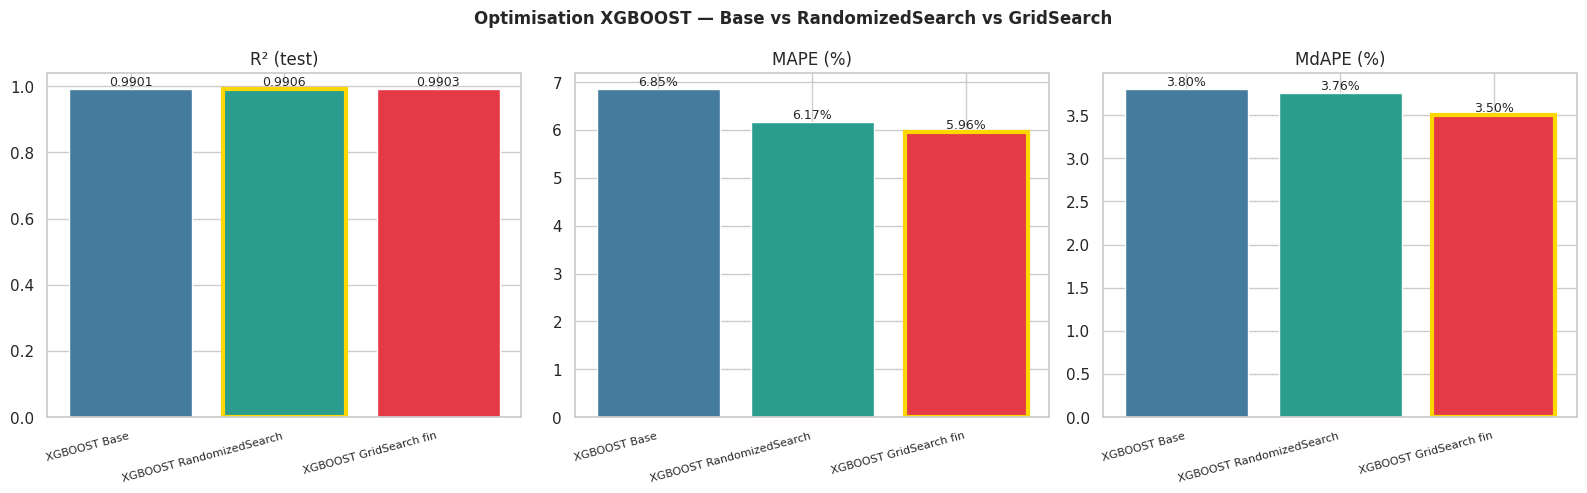

In [31]:

# Graphique comparatif des 3 versions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle(f'Optimisation {MODEL_TO_TUNE.upper()} — Base vs RandomizedSearch vs GridSearch',
             fontsize=12, fontweight='bold')

colors = ['#457b9d', '#2a9d8f', '#e63946']

for ax, (metric, label, better) in zip(axes, [
    ('R² test',    'R² (test)', 'max'),
    ('MAPE (%)',   'MAPE (%)',  'min'),
    ('MdAPE (%)',  'MdAPE (%)', 'min'),
]):
    vals   = comp_df[metric]
    bars   = ax.bar(vals.index, vals.values, color=colors)
    best_v = vals.max() if better == 'max' else vals.min()
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.002,
                f'{v:.4f}' if metric == 'R² test' else f'{v:.2f}%',
                ha='center', va='bottom', fontsize=9)
        if v == best_v:
            bar.set_edgecolor('gold')
            bar.set_linewidth(3)
    ax.set_title(label)
    ax.set_xticklabels(vals.index, rotation=15, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

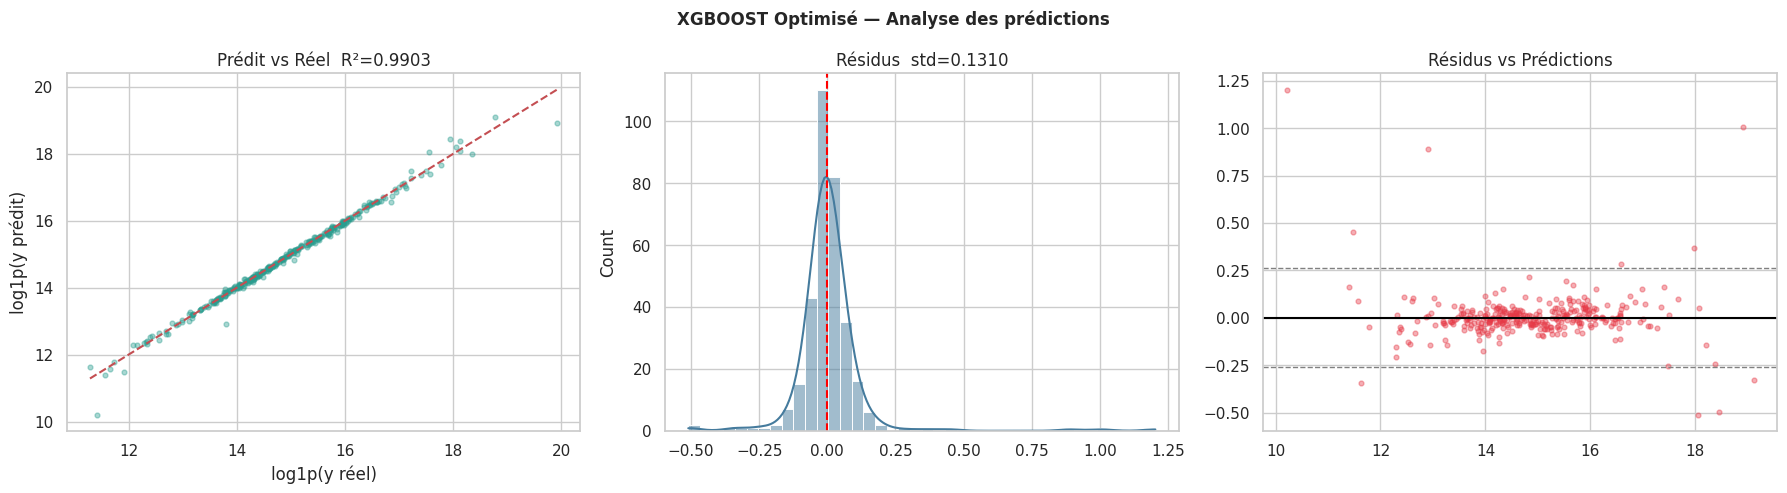

In [32]:
best_optimized = grid_search  # modèle final optimisé
y_pred_opt     = best_optimized.predict(X_test)
y_pred_opt_real = np.expm1(y_pred_opt)
residuals_opt   = y_test.values - y_pred_opt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'{MODEL_TO_TUNE.upper()} Optimisé — Analyse des prédictions',
             fontsize=12, fontweight='bold')

# Prédit vs réel
axes[0].scatter(y_test, y_pred_opt, alpha=0.4, s=12, color='#2a9d8f')
lims = [y_test.min(), y_test.max()]
axes[0].plot(lims, lims, 'r--', lw=1.5)
axes[0].set_xlabel('log1p(y réel)')
axes[0].set_ylabel('log1p(y prédit)')
axes[0].set_title(f'Prédit vs Réel  R²={r2_score(y_test, y_pred_opt):.4f}')

# Résidus
sns.histplot(residuals_opt, bins=40, kde=True, ax=axes[1], color='#457b9d')
axes[1].axvline(0, color='red', linestyle='--', lw=1.5)
axes[1].set_title(f'Résidus  std={residuals_opt.std():.4f}')

# Résidus vs prédictions
axes[2].scatter(y_pred_opt, residuals_opt, alpha=0.4, s=12, color='#e63946')
axes[2].axhline(0, color='black', lw=1.5)
axes[2].axhline( 2*residuals_opt.std(), color='gray', linestyle='--', lw=1)
axes[2].axhline(-2*residuals_opt.std(), color='gray', linestyle='--', lw=1)
axes[2].set_title('Résidus vs Prédictions')

plt.tight_layout()
plt.show()

In [ ]:
import os
os.makedirs(MODEL_DIR, exist_ok=True)

final_model = grid_search.best_estimator_
model_path  = f'{MODEL_DIR}model_energy_{MODEL_TO_TUNE}_optimized.pkl'
joblib.dump(final_model, model_path)

# Sauvegarder les meilleurs hyperparamètres
params_path = f'{MODEL_DIR}best_params_energy_{MODEL_TO_TUNE}.json'
import json
with open(params_path, 'w') as f:
    json.dump(grid_search.best_params_, f, indent=2)

r2_final   = r2_score(y_test, best_optimized.predict(X_test))
mape_final_v = np.mean(np.abs(
    (y_test_real - np.expm1(best_optimized.predict(X_test))) / y_test_real.clip(lower=1)
)) * 100

print(f' Modèle optimisé sauvegardé : {model_path}')
print(f'Hyperparamètres sauvegardés : {params_path}')
print()
print('═' * 55)